In [1]:
from sentinelhub import SHConfig

config = SHConfig()

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

In [4]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
def space_usability(coords, time_interval, resolution=60, red_clouds=True, red_factor=200, display=False):
    box = BBox(bbox=coords, crs=CRS.WGS84)
    size = bbox_to_dimensions(box, resolution=resolution)

    clouds = ', "CLM"' if red_clouds else ''

    script = f"""
        //VERSION=3
        function setup() {{
            return {{
                input: ["B02", "B03", "B04"{clouds}],
                output: {{ bands: 3 }}
            }}
        }}

        function evaluatePixel(sample) {{
            if (sample.CLM == 1) {{
                return [0.75 + sample.B04, sample.B03, sample.B02]
            }}
            return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
        }}
    """

    request_true_color = SentinelHubRequest(
        evalscript=script,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC',
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=box,
        size=size,
        config=config
    )

    data = request_true_color.get_data()[0]

    red = data[:,:,0]
    red_percent = np.sum(np.where(red > red_factor, 1, 0)) / (red.shape[0] * red.shape[1])

    if display:
        plot_image(data, factor=1/255, clip_range=(0,1))

    return red_percent, data

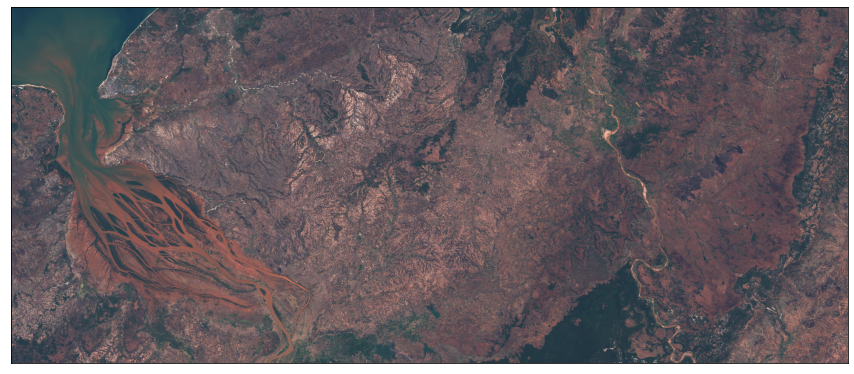

In [13]:
coords = [46.16, -16.15, 47.51, -15.58]
time_interval = ('2020-06-12', '2020-06-22')
red, image = space_usability(coords, time_interval, red_clouds=False, display=True)

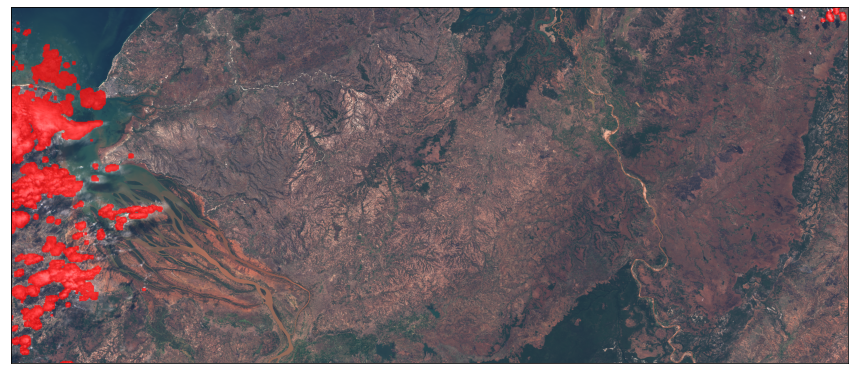

In [12]:
coords = [46.16, -16.15, 47.51, -15.58]
time_interval = ('2020-06-12', '2020-06-13')
red, image = space_usability(coords, time_interval, red_clouds=True, display=True)